### Import libraries

In [5]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from time import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
#from pandas.plotting import scatter_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l1_l2

# import tensorflow as tf
# from keras.regularizers import l1_l2
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras import regularizers

ModuleNotFoundError: No module named 'tensorflow'

# Download Data

### CCAR Variables

In [ ]:
# Time period of 41+ years
end = '2023-04-30'
start = '1982-1-1'

# FRED, Bloomberg, Yahoo Finance Data
Y_ticker = ["^VIX"]
X_ticker1 = ["SPY","GC=F","DX-Y.NYB"]
Fred_data1 = ["GDP","GDPC1","A067RL1Q156SBEA","A067RP1Q027SBEA","UNRATE","CPIAUCSL","TB3MS","GS5","GS10","MPRIME","BOGZ1FL075035243Q","BOGZ1FL075035503Q"]
Fred_data2 = ["MORTGAGE30US"]
#X1 = yf.download(Y_ticker, start=start, end=end, progress = False,group_by="ticker")
X2 = web.DataReader(Fred_data1,'fred',start,end)
Y = yf.download(Y_ticker, start=start, end=end, progress = False,group_by="ticker")
Y = pd.DataFrame(Y['Adj Close'])
X3 = web.DataReader(Fred_data2,'fred','1981-12-01','2023-04-30')
Dow_jones = web.DataReader('BOGZ1FL073164013Q','fred',start,end)
Y_SPX = yf.download('^SPX',start='2010-04-30', end='2023-04-30', progress = False,group_by="ticker")
Y_SPX = pd.DataFrame(Y_SPX['Adj Close'])


### Additional Variables

In [ ]:
# FRED, Bloomberg, Yahoo Finance Data
Fred_data3 = ["UMCSENT","DFF","PPIACO","M1SL","M2SL","ICSA","STLFSI4","BAMLC0A4CBBB"]

#X1 = yf.download(Y_ticker, start=start, end=end, progress = False,group_by="ticker")
X2_add = web.DataReader(Fred_data3,'fred',start,end)
dollar= yf.download('DX-Y.NYB', start=start, end=end, progress = False,group_by="ticker")
dollar = pd.DataFrame(dollar['Adj Close'])

### Define Column names

In [ ]:
# Define column names
col_name1={'GDP':'Nom GDP', 'GDPC1':'Real GDP','A067RL1Q156SBEA':'Real Disp Income','A067RP1Q027SBEA':'Nom Disp Income','UNRATE':'Unemp Rate','CPIAUCSL':'CPI','TB3MS':'3m TSY','GS5':'5Y TSY','GS10':'10Y TSY','MPRIME':'Prime Rate', 'BOGZ1FL075035243Q': 'HPI', 'BOGZ1FL075035503Q': 'Commercial REI'}
col_name2 = {'MORTGAGE30US':'Mortgage Rate'}
dj_col = {'BOGZ1FL073164013Q':'Dow Jones Total'}
Y_col = {'Adj Close':'VIX'}

# Additional variables column names
col_names_add = {'UMCSENT':'MCSI', 'DFF': 'Effective Federal Fund Rate', 'PPIACO': 'PPI', 'M1SL': 'M1','M2SL':'M2','ICSA': 'ICSA','STLFSI4': 'Federal Stress Index','BAMLC0A4CBBB': 'OAS BBB Corp'}
dollar_col = {'Adj Close': 'Dollar'}

# Functions

In [ ]:
# Function to convert datetime to date only
def date_time(S):
    S.index = S.index.date
    S.index = pd.to_datetime(S.index)
    return S

In [ ]:
# Function to rename columns
def rename_columns(S,column_name):
    S = S.rename(columns=column_name)
    return S

In [ ]:
# Function to convert weekly to monthly data (One period forward shift)
def weekly_to_monthly(S):
    monthly = S.resample('MS').mean()
    monthly.index = monthly.index.shift(1,freq='MS')
    return monthly

In [ ]:
# Function to calculate growth rate and convert to month
def growth_calc_to_monthly(S,n):
    growth1 = pd.DataFrame(S.dropna())
    growth2 = (((1+ growth1.pct_change())**4)-1)*100
    growth2.index = growth2.index.shift(3,freq='MS')
    growth2 = growth2.asfreq('MS',method='ffill')/n
    return growth2

In [ ]:
# Function to convert quarterly to monthly (Forwardfill)
def quarterly_to_monthly_forwardfill(S,n):
    monthly = pd.DataFrame(S.dropna())
    monthly.index = monthly.index.shift(3,freq='MS')
    monthly = monthly.asfreq('MS',method='ffill')/n
    return monthly

In [ ]:
# Function to convert quarterly to monthly (Backfill)
def quarterly_to_monthly_backfill(S,n):
    monthly = pd.DataFrame(S.dropna().asfreq('MS',method='bfill')/n)
    return monthly

# Code

### Renaming columns

In [ ]:
# Rename columns by replacing ticker names with actual variable names
fred_1 = rename_columns(X2,col_name1)
fred_2 = rename_columns(X3,col_name2)
Dow_jones_qtr = rename_columns(Dow_jones,dj_col)
Y = rename_columns(Y,Y_col)
dollar = rename_columns(dollar,dollar_col)

# Additonal variables data
fred_3 = rename_columns(X2_add,col_names_add)

In [ ]:
# Changing datetime variables to date only variables
dollar_index = date_time(dollar)
Y_index = date_time(Y)

# Max value of VIX and Last value of Dollar Index
VIX_monthly = Y_index.resample('MS').max()
dollar_monthly = dollar_index.resample('MS').last()
SPX_monthly = Y_SPX.resample('MS').last()
VIX_monthly

,VIX
1990-01-01,27.250000
1990-02-01,24.870001
1990-03-01,22.740000
1990-04-01,24.160000
1990-05-01,20.139999
...,...
2022-12-01,25.000000
2023-01-01,22.900000
2023-02-01,22.870001
2023-03-01,26.520000


### Extracting Data from initial dataframe

In [ ]:
# Extract each variable from dataframe and store in Dataframe
real_gdp_qtr = pd.DataFrame(fred_1['Real GDP'])
nom_gdp_qtr = pd.DataFrame(fred_1['Nom GDP'])
nom_disp_inc_qtr = pd.DataFrame(fred_1['Nom Disp Income'])
real_disp_inc_qtr = pd.DataFrame(fred_1['Real Disp Income'])
unemp_rate_monthly = pd.DataFrame(fred_1['Unemp Rate'])
CPI_monthly = pd.DataFrame(fred_1['CPI'])
tsy_3m_monthly = pd.DataFrame(fred_1['3m TSY'])
tsy_5y_monthly = pd.DataFrame(fred_1['5Y TSY'])
tsy_10y_monthly = pd.DataFrame(fred_1['10Y TSY'])
prime_rate_monthly = pd.DataFrame(fred_1['Prime Rate'])
HPI_qtr = pd.DataFrame(fred_1['HPI'])
REI_qtr = pd.DataFrame(fred_1['Commercial REI'])

### Data Cleaning

In [ ]:
# Convert weekly data to monthly data
mortgage_monthly = weekly_to_monthly(fred_2)

# Convert quarterly data to monthly data
nom_disp_inc_monthly = quarterly_to_monthly_forwardfill(nom_disp_inc_qtr,3)
real_disp_inc_monthly = quarterly_to_monthly_forwardfill(real_disp_inc_qtr,3)
nom_gdp_monthly_growth = growth_calc_to_monthly(nom_gdp_qtr,3)
real_gdp_monthly_growth = growth_calc_to_monthly(real_gdp_qtr,3)
HPI_monthly = quarterly_to_monthly_forwardfill(HPI_qtr,1000)
REI_monthly = quarterly_to_monthly_forwardfill(REI_qtr,1000)
Dow_jones_monthly = quarterly_to_monthly_forwardfill(Dow_jones_qtr,1000)

### Combining to DataFrame

In [ ]:
# Combining all cleaned variables in one dataframe
cols = [real_gdp_monthly_growth,nom_gdp_monthly_growth,real_disp_inc_monthly,nom_disp_inc_monthly,unemp_rate_monthly,CPI_monthly,tsy_3m_monthly,tsy_5y_monthly,tsy_10y_monthly,mortgage_monthly,prime_rate_monthly,Dow_jones_monthly,HPI_monthly,REI_monthly]
combined_data = pd.concat(cols,axis = 1)
combined_data1 = combined_data.drop(combined_data.index[:3])
ccar_data = combined_data1.drop(combined_data.index[-2:])
missing_value_column = ['Dow Jones Total', 'HPI', 'Commercial REI']
ccar_data.loc[:, missing_value_column] = ccar_data.loc[:, missing_value_column].fillna(method='ffill', limit=2)
ccar_data
# combining both dependent and independent variables
ccar_data_combined = pd.concat([ccar_data,VIX_monthly],axis =1)
ccardata_comb = ccar_data_combined.dropna()
ccardata_comb.describe()

,Real GDP,Nom GDP,Real Disp Income,Nom Disp Income,Unemp Rate,CPI,3m TSY,5Y TSY,10Y TSY,Mortgage Rate,Prime Rate,Dow Jones Total,HPI,Commercial REI,VIX
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,0.829000,1.608876,0.916792,1.658647,5.811529,201.626664,2.547419,3.735714,4.255038,5.963202,5.727895,15133.425414,144.072060,184.205293,23.681153
std,1.561741,1.748093,2.506743,2.479248,1.739121,43.807750,2.213853,2.189329,2.015092,1.909983,2.230518,10375.017998,56.441471,74.593311,10.087809
min,-9.952473,-10.301345,-9.600000,-8.066667,3.400000,127.500000,0.010000,0.270000,0.620000,2.684000,3.250000,2879.340000,74.934000,86.351000,11.300000
25%,0.467187,1.162515,0.366667,1.100000,4.500000,162.400000,0.165000,1.700000,2.525000,4.182000,3.250000,8343.190000,87.883000,120.832000,16.600000
50%,0.859433,1.655814,0.966667,1.633333,5.500000,202.000000,2.120000,3.490000,4.130000,6.047500,5.250000,12032.450000,139.282000,172.464000,21.440001
75%,1.309123,2.169926,1.400000,2.133333,6.700000,236.992000,4.720000,5.560000,5.810000,7.399750,8.175000,20458.820000,182.657000,240.604000,27.865000
max,11.772380,13.354576,17.466667,19.733333,14.700000,301.808000,7.900000,8.770000,8.890000,10.477500,10.110000,48634.310000,297.598000,356.668000,82.690002


### Additional Variable Cleaning

In [ ]:
# fred_add_var = fred_3.resample('MS').mean()
# new_cols = [fred_add_var,dollar_monthly]
# add_var = pd.concat(new_cols,axis=1)

# # ls = ['MCSI', 'Effective Federal Fund Rate', 'PPI', 'M1','M2','ICSA','Federal Stress Index','OAS BBB Corp']

# # fred_add_var['PPI'] = fred_add_var['PPI'].pct_change()
#add_var

<Axes: >

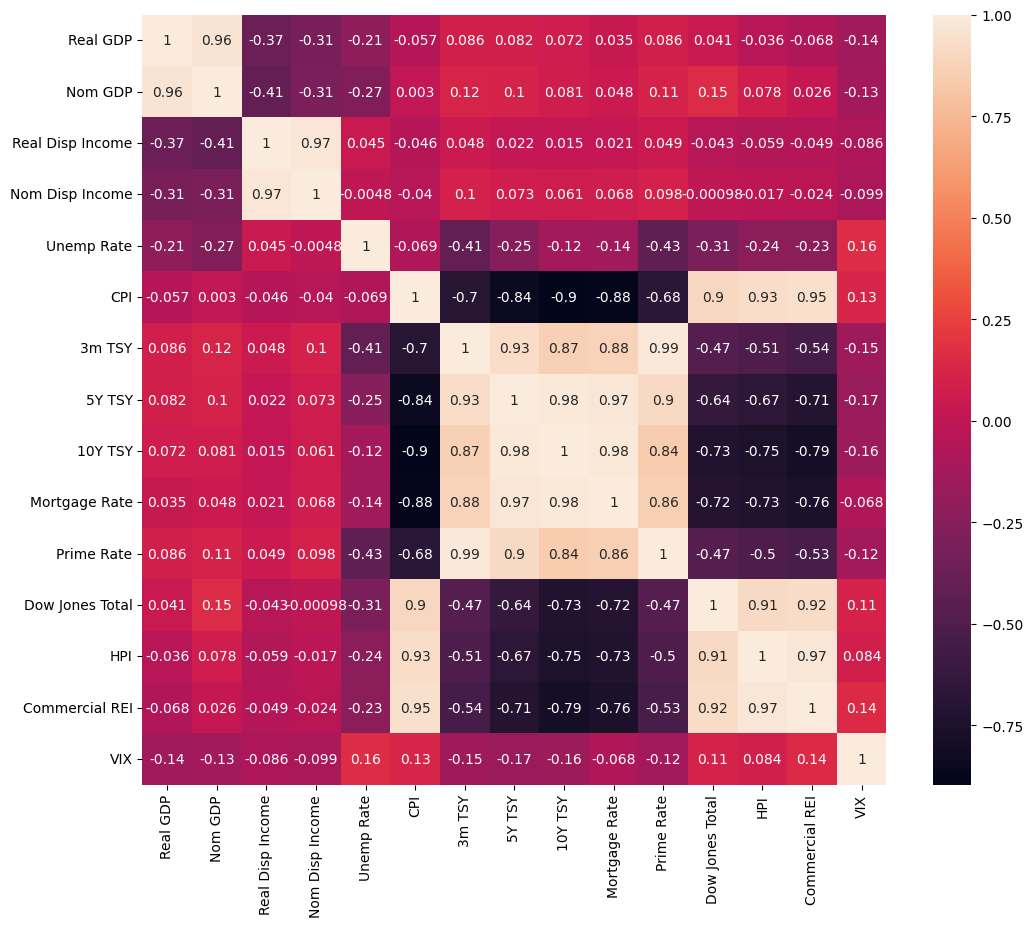

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(ccardata_comb.corr(),annot=True)

In [ ]:
plt.figure()
sns.pairplot(ccardata_comb)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
correlation_matrix = ccardata_comb.corr()

# Get the variable names with correlation greater than 0.4
variables = correlation_matrix.columns
strong_correlation_variables = []

for var1 in variables:
    for var2 in variables:
        if var1 != var2 and correlation_matrix.loc[var1, var2] > 0.4:
            strong_correlation_variables.append((var1, var2))

# Print the variable pairs with correlation greater than 0.4
for pair in strong_correlation_variables:
    print(f"{pair[0]} and {pair[1]} have a correlation greater than 0.4.")

Real GDP and Nom GDP have a correlation greater than 0.4.
Nom GDP and Real GDP have a correlation greater than 0.4.
Real Disp Income and Nom Disp Income have a correlation greater than 0.4.
Nom Disp Income and Real Disp Income have a correlation greater than 0.4.
CPI and Dow Jones Total have a correlation greater than 0.4.
CPI and HPI have a correlation greater than 0.4.
CPI and Commercial REI have a correlation greater than 0.4.
3m TSY and 5Y TSY have a correlation greater than 0.4.
3m TSY and 10Y TSY have a correlation greater than 0.4.
3m TSY and Mortgage Rate have a correlation greater than 0.4.
3m TSY and Prime Rate have a correlation greater than 0.4.
5Y TSY and 3m TSY have a correlation greater than 0.4.
5Y TSY and 10Y TSY have a correlation greater than 0.4.
5Y TSY and Mortgage Rate have a correlation greater than 0.4.
5Y TSY and Prime Rate have a correlation greater than 0.4.
10Y TSY and 3m TSY have a correlation greater than 0.4.
10Y TSY and 5Y TSY have a correlation greater 

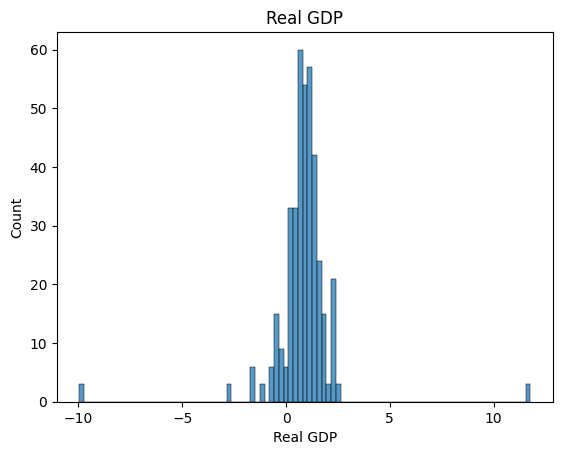

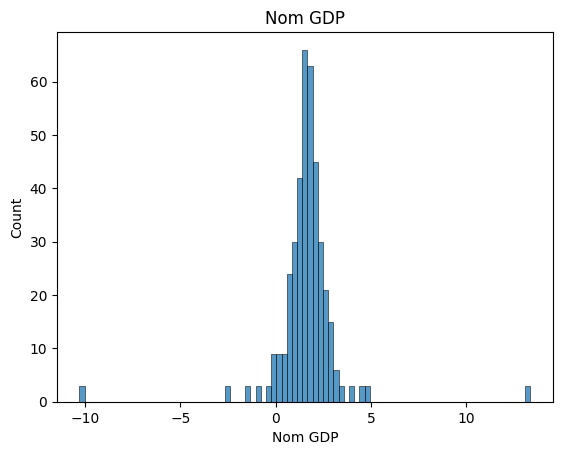

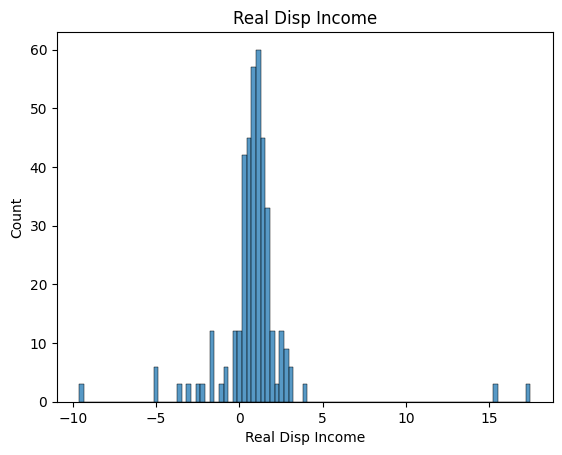

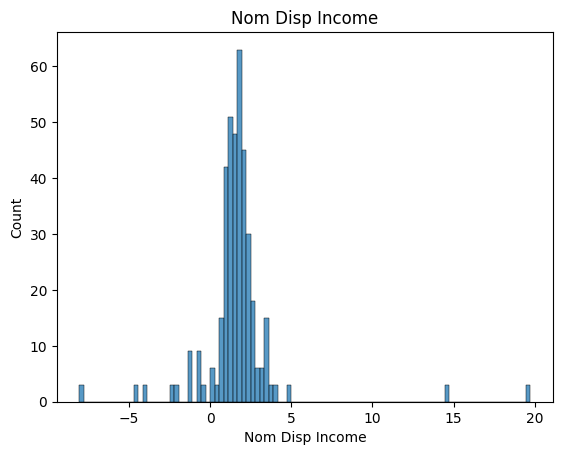

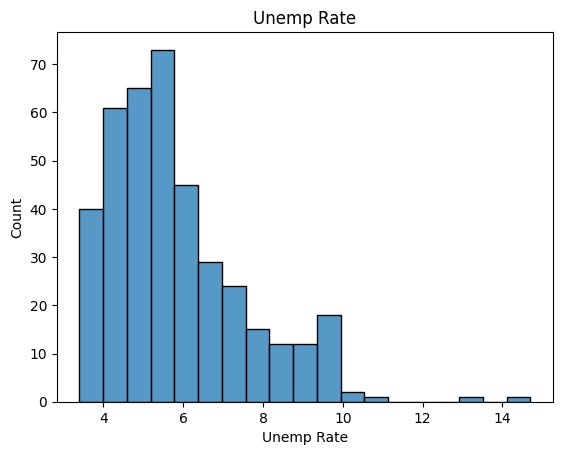

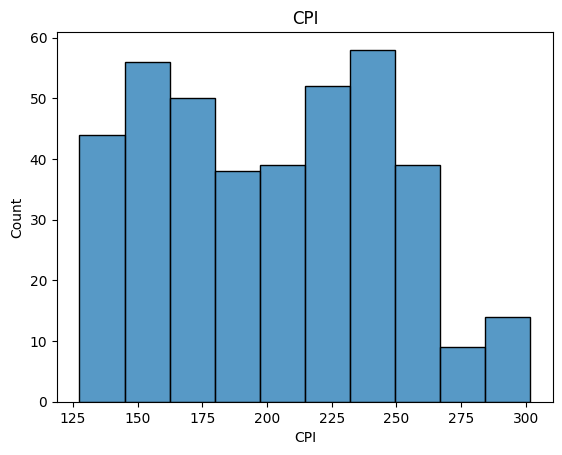

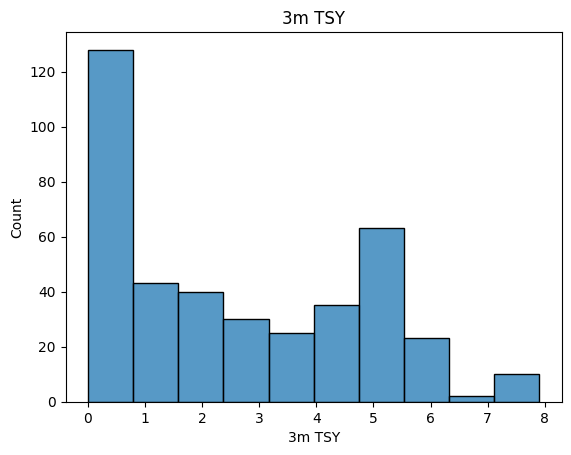

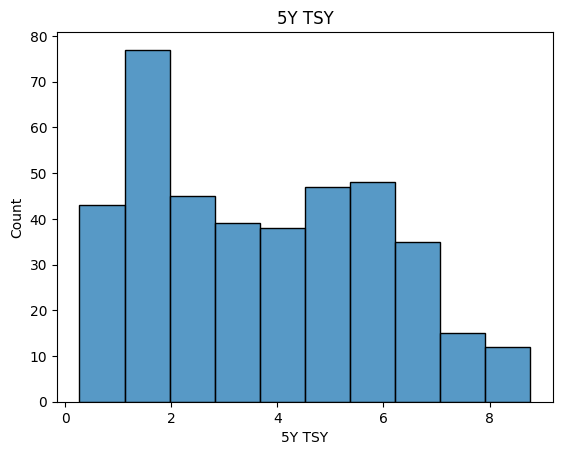

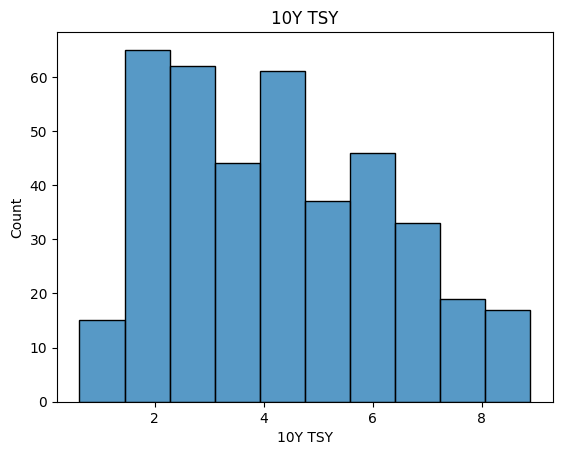

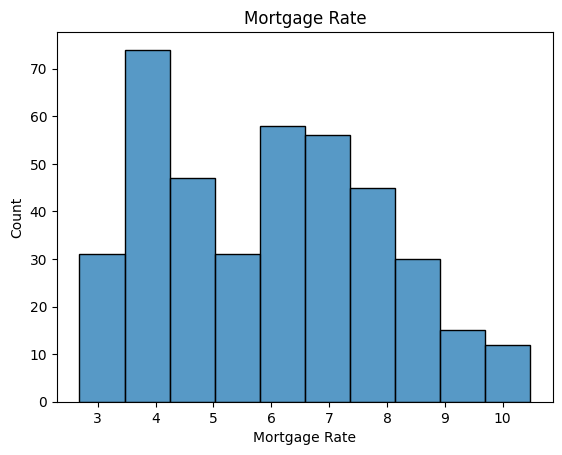

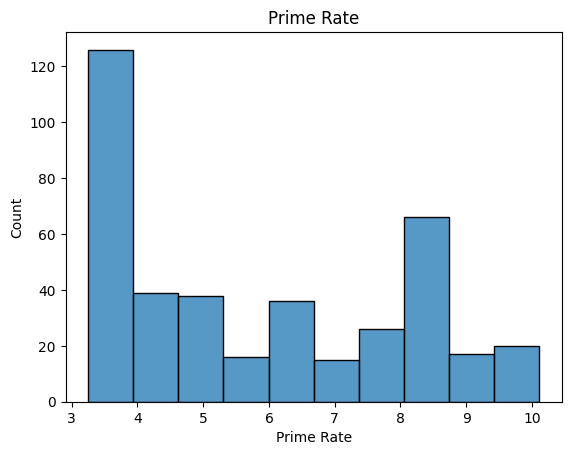

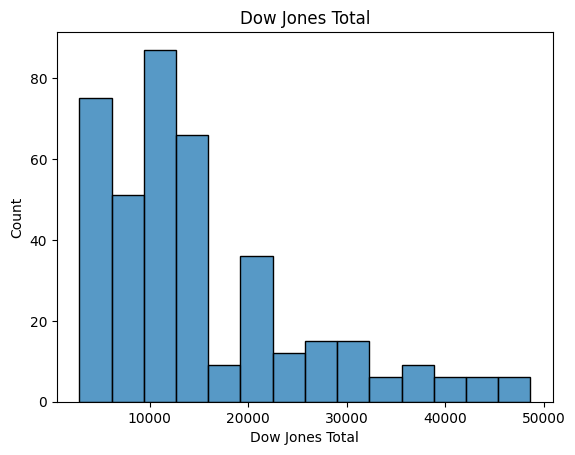

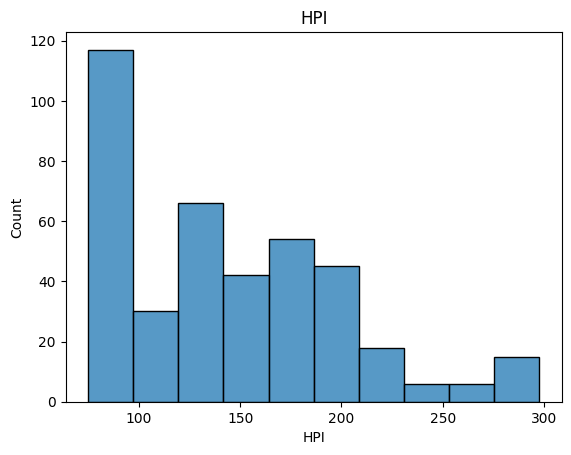

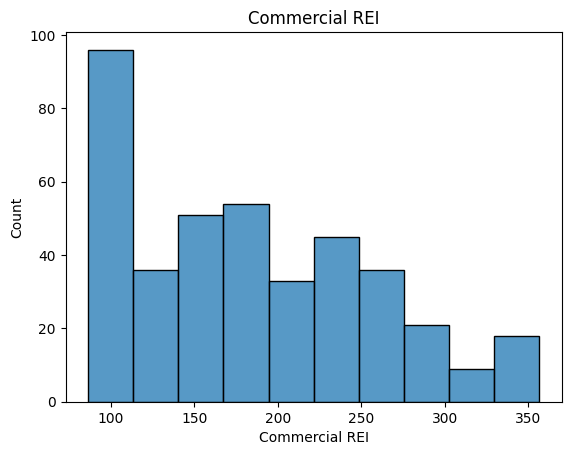

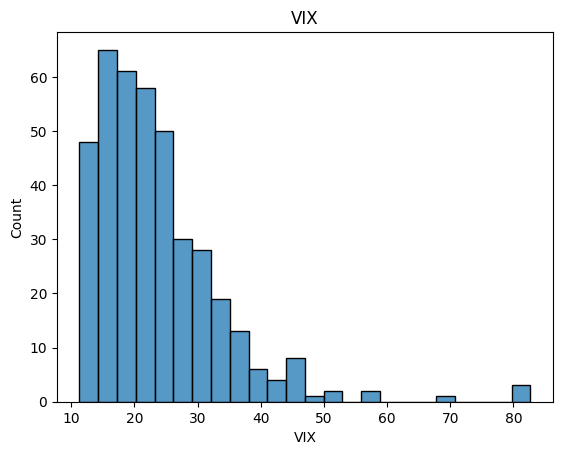

In [ ]:
for i in range (len(cols)+1):
  #plt.subplot(i+1,1,1)
  plt.figure()
  #plt.subplot(nrows = 3,ncols =5)
  sns.histplot(ccardata_comb.iloc[:,i])
  plt.title(ccardata_comb.columns[i])
  plt.show()

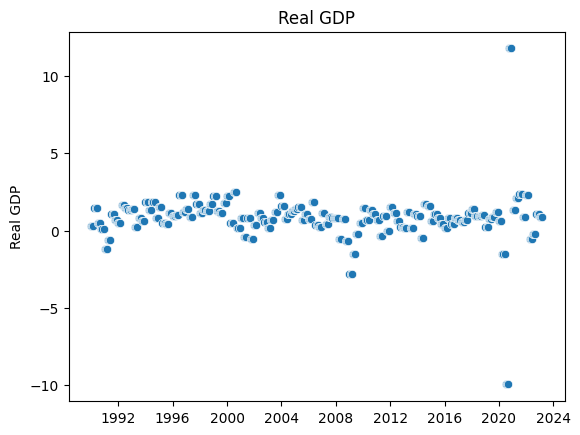

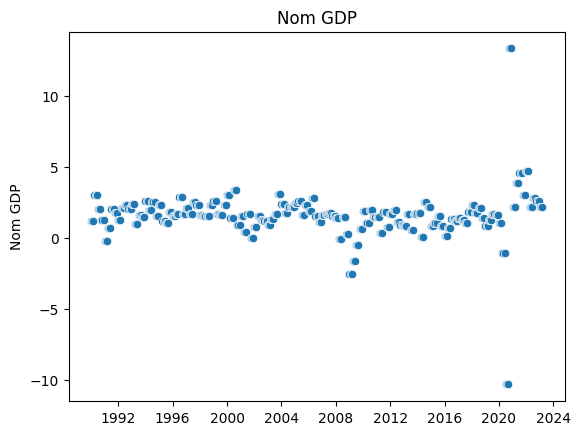

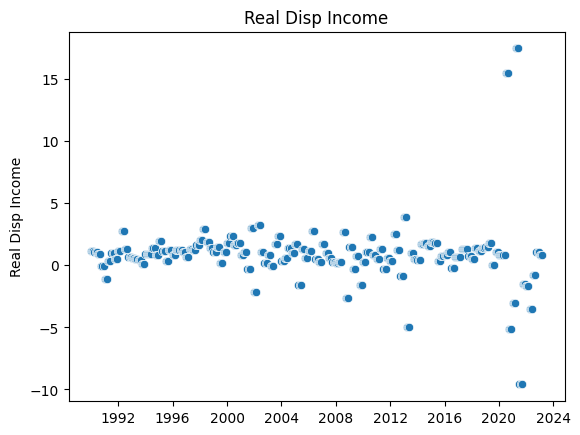

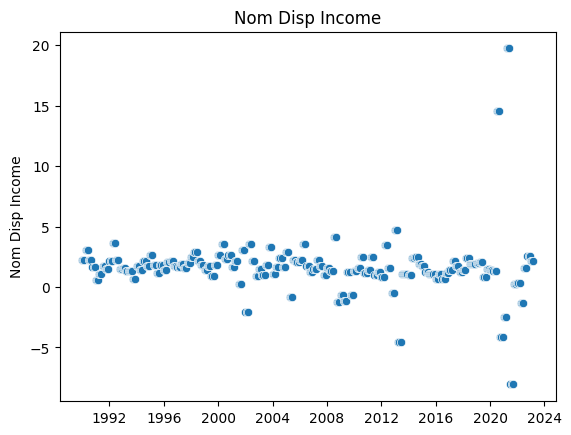

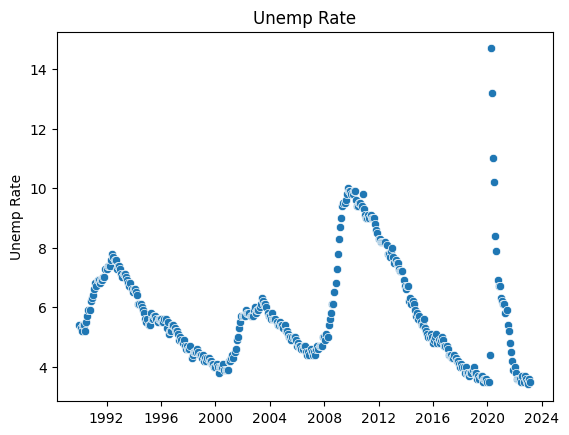

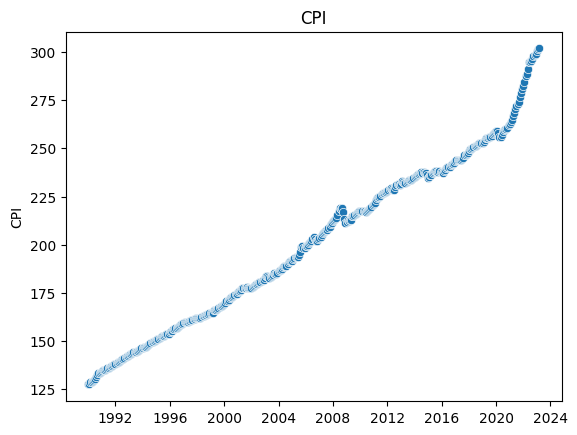

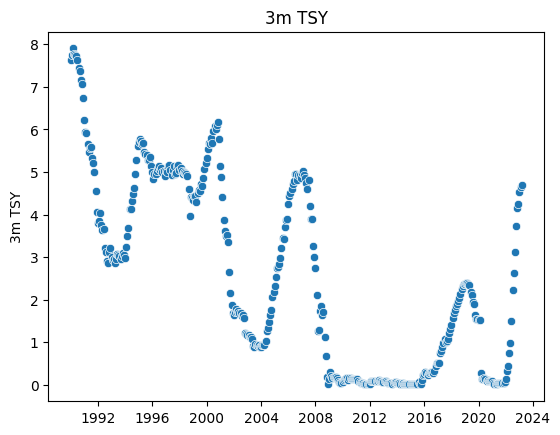

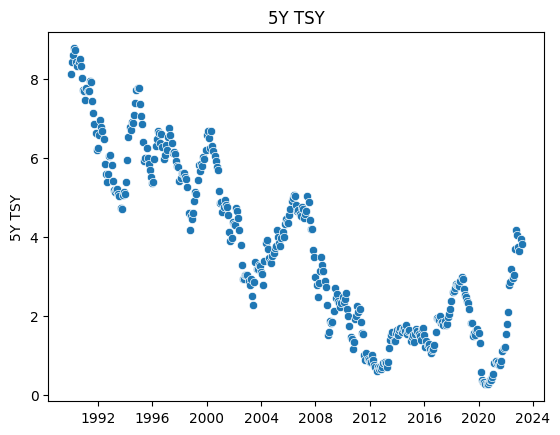

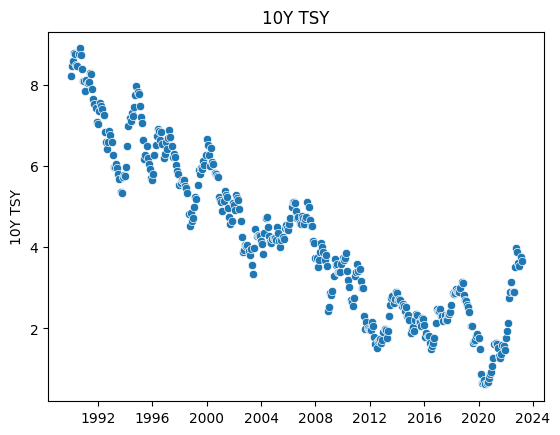

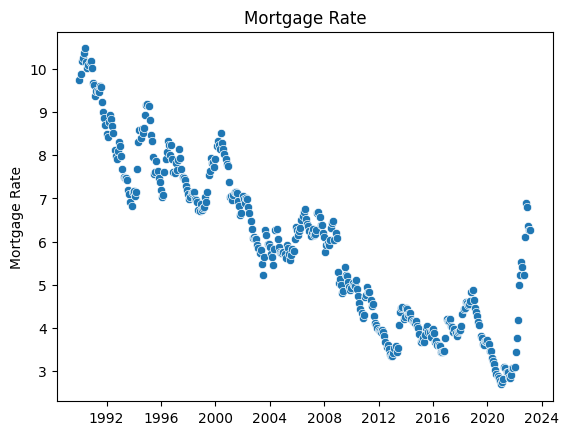

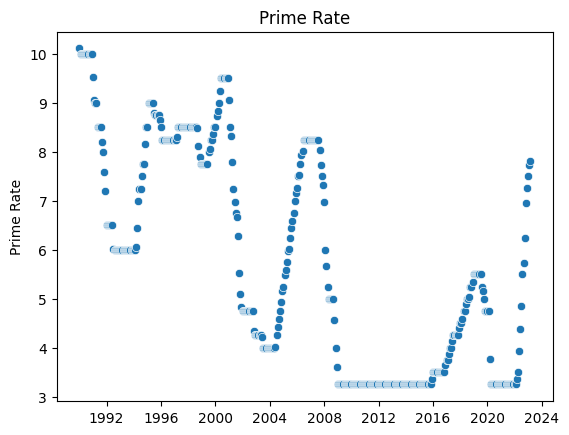

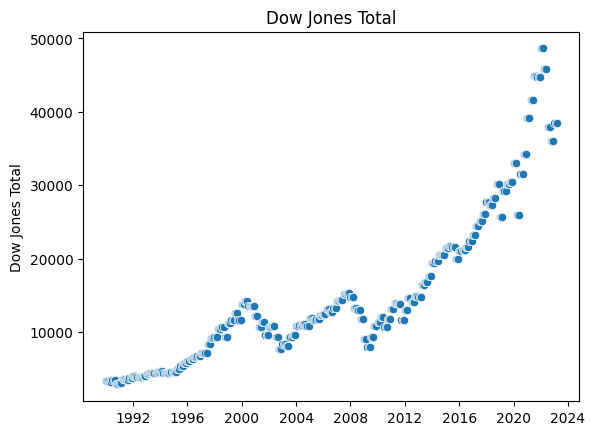

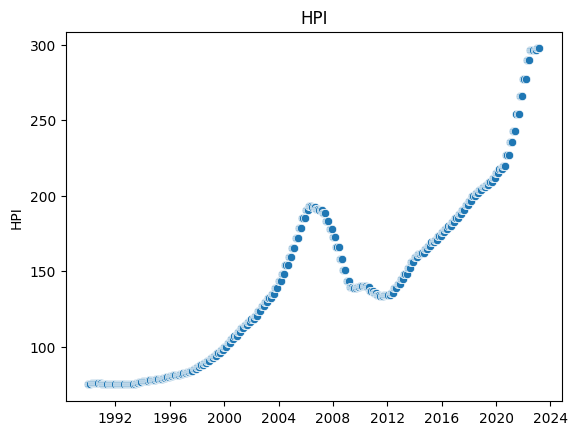

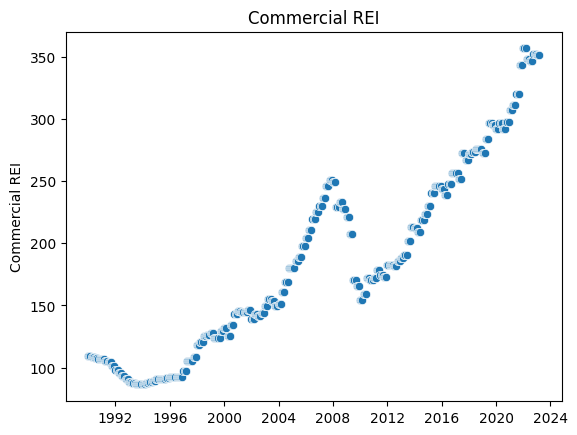

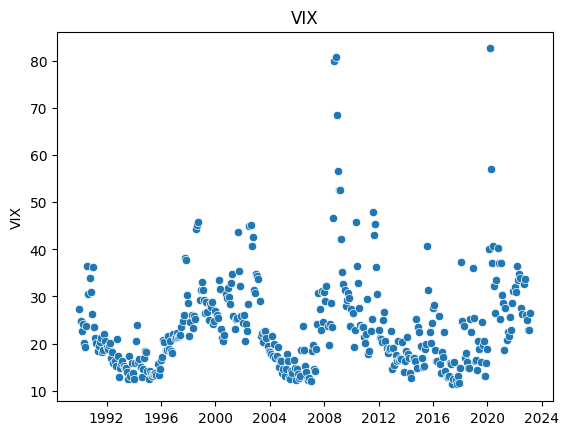

In [ ]:
for i in range (len(cols)+1):
  #plt.subplot(i+1,1,1)
  plt.figure()
  #plt.subplot(nrows = 3,ncols =5)
  sns.scatterplot(ccardata_comb.iloc[:,i])
  plt.title(ccardata_comb.columns[i])
  plt.show()

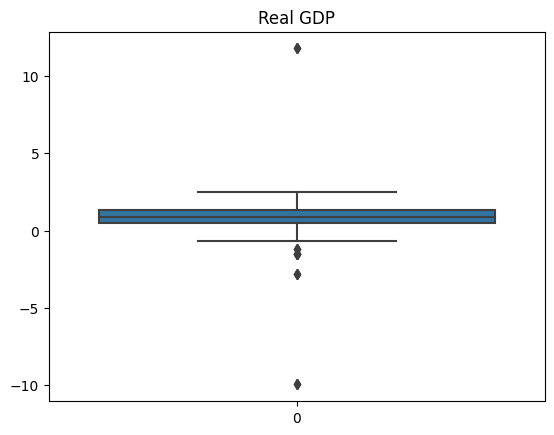

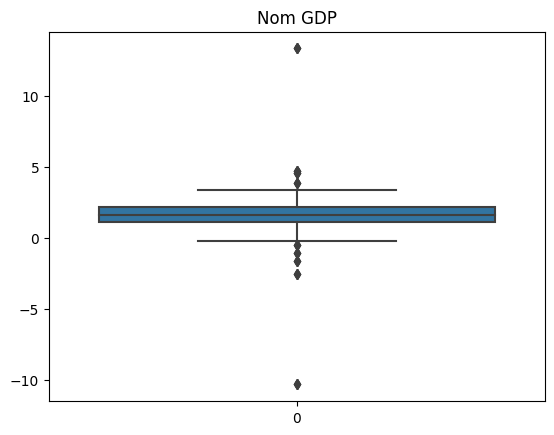

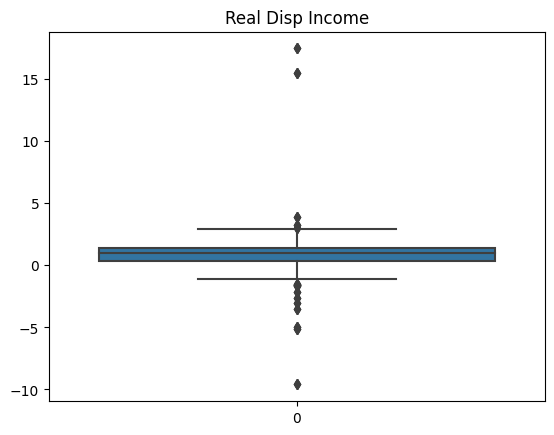

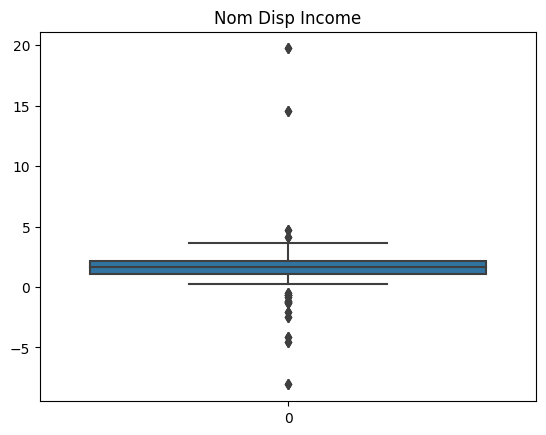

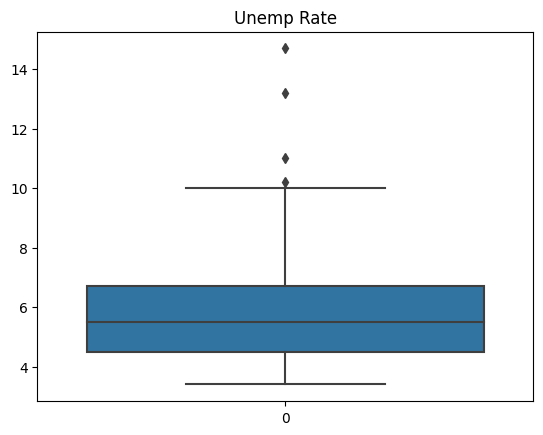

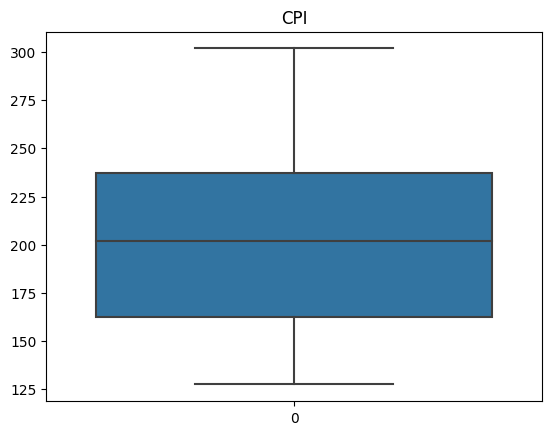

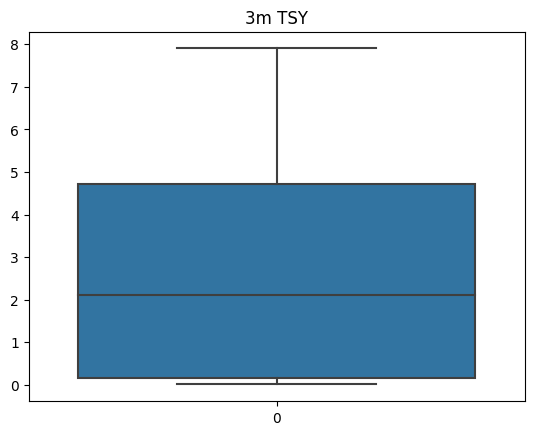

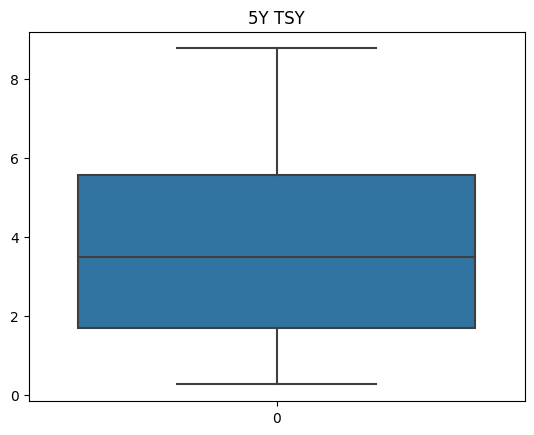

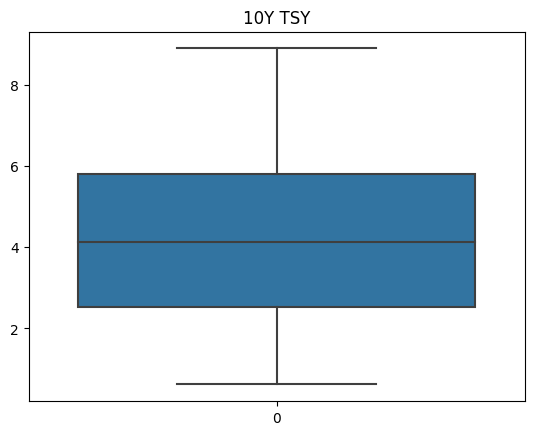

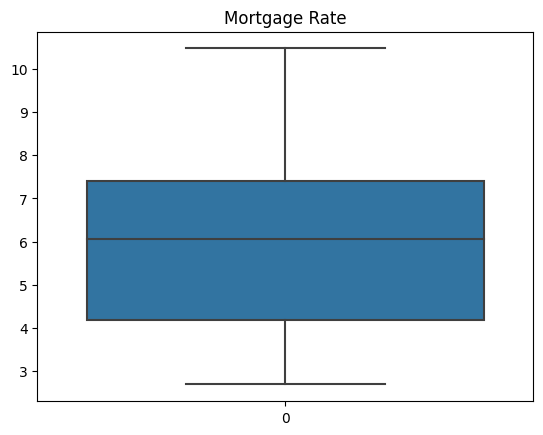

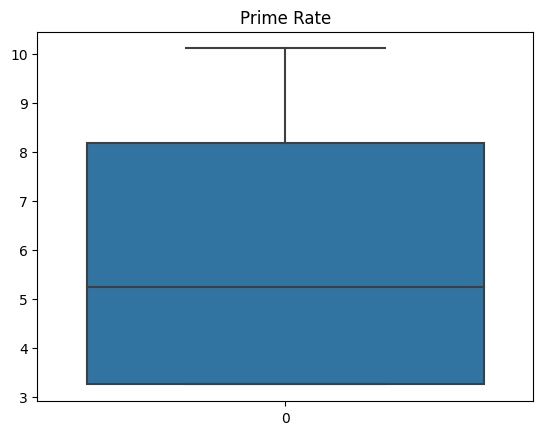

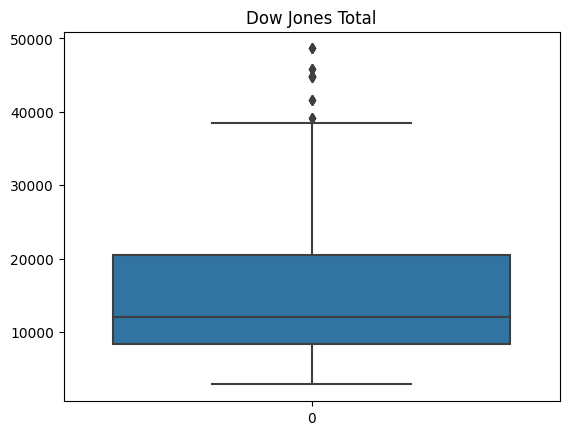

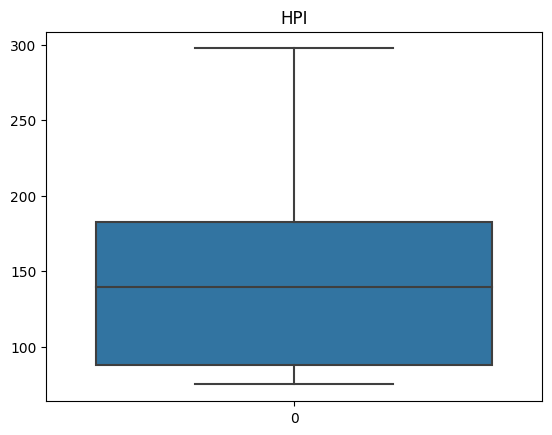

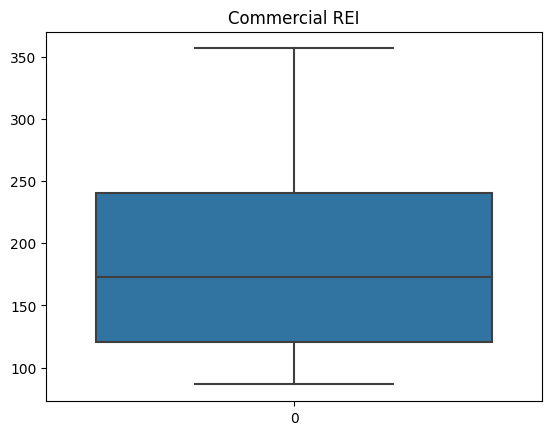

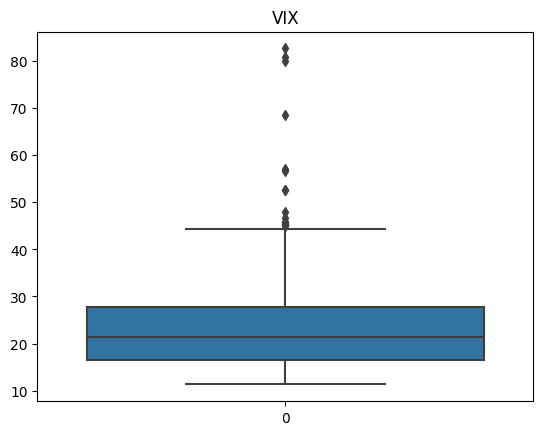

In [ ]:
for i in range (len(cols)+1):
  #plt.subplot(i+1,1,1)
  plt.figure()
  #plt.subplot(nrows = 3,ncols =5)
  sns.boxplot(ccardata_comb.iloc[:,i])
  plt.title(ccardata_comb.columns[i])
  plt.show()

In [ ]:
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
train_x, test_x, train_y,test_y = train_test_split(ccardata_comb.iloc[:,0:14],ccardata_comb.iloc[:,-1],test_size=0.20,shuffle=False)

from sklearn.preprocessing import RobustScaler, StandardScaler
# ss = RobustScaler()
# ss.fit(train_x)
# scaled_t_train = ss.transform(train_x)
# scaled_t_test = ss.transform(test_x)
# #(pd.DataFrame(scaled_data)).describe()
# #np.describe(scaled_data)
# (pd.DataFrame(scaled_t_test)).describe()

In [ ]:
ss = StandardScaler()
ss.fit(train_x)
scaled_t_train = ss.transform(train_x)
scaled_t_test = ss.transform(test_x)
#(pd.DataFrame(scaled_data)).describe()
#np.describe(scaled_data)
(pd.DataFrame(scaled_t_test)).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,0.018500,0.485379,0.013218,0.214666,-0.826506,2.245791,-0.679902,-1.075547,-1.401302,-1.385631,-0.721092,4.378383,2.651435,2.746951
std,3.775206,3.852462,4.364617,4.082871,1.330149,0.526435,0.534726,0.478213,0.455698,0.554113,0.503999,1.547095,0.970437,0.644638
min,-13.150149,-13.158441,-8.978637,-7.916970,-1.723741,1.597316,-1.238786,-1.824405,-2.222398,-2.135697,-1.219055,2.183243,1.462827,1.789101
25%,-0.287702,-0.292416,-1.435015,-0.693851,-1.529919,1.877883,-1.183170,-1.427521,-1.712342,-1.793705,-1.219055,3.085838,1.946657,2.261058
50%,0.071124,0.290101,-0.097089,-0.168657,-1.336097,2.074879,-0.789498,-1.100266,-1.375866,-1.453838,-0.785431,3.918035,2.279729,2.645401
75%,0.459465,1.181133,0.358374,0.349716,-0.803086,2.525577,-0.354387,-0.703382,-1.034049,-1.126718,-0.434195,5.583294,3.375791,3.186478
max,13.355101,13.169971,14.136159,14.836878,5.576894,3.402909,0.798277,-0.009415,-0.427857,0.252935,0.762608,7.618139,4.490445,3.898532


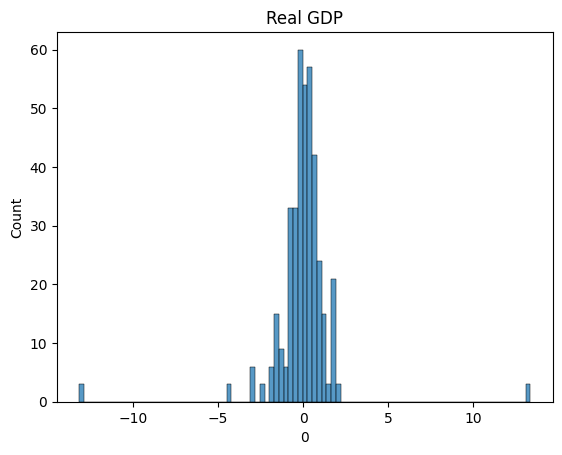

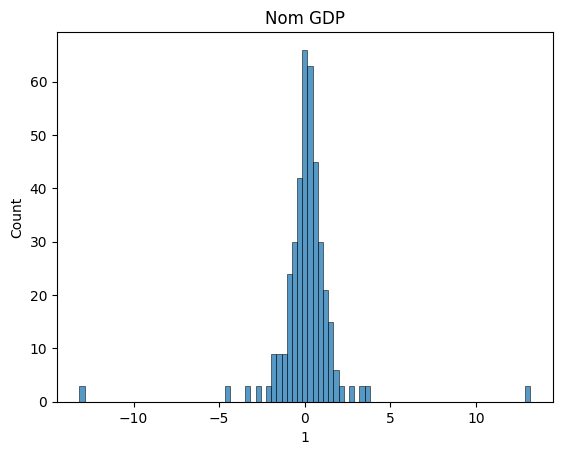

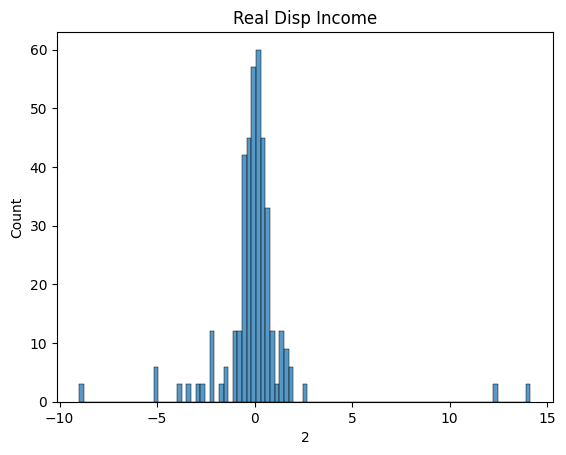

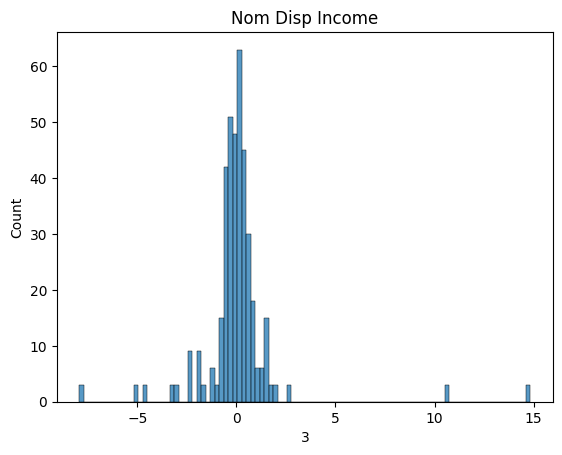

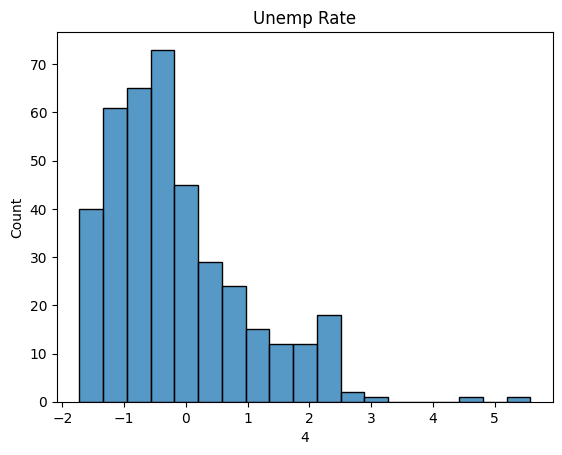

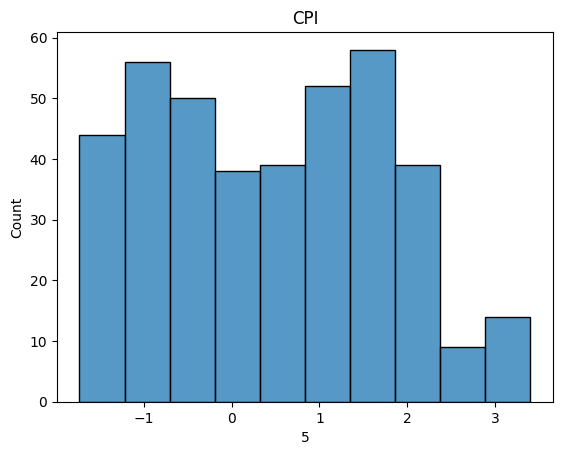

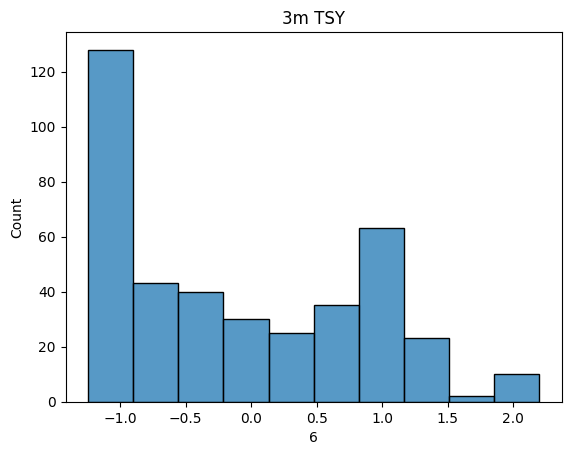

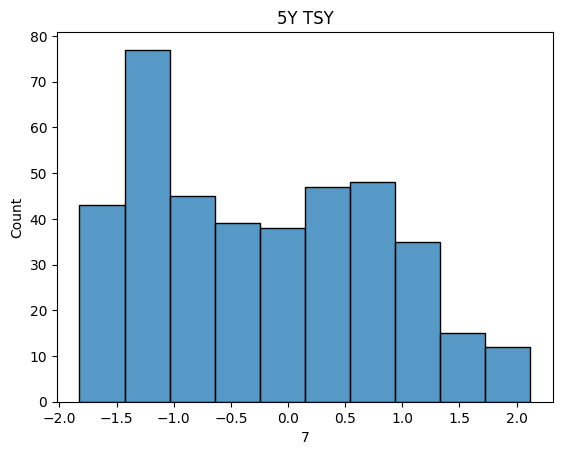

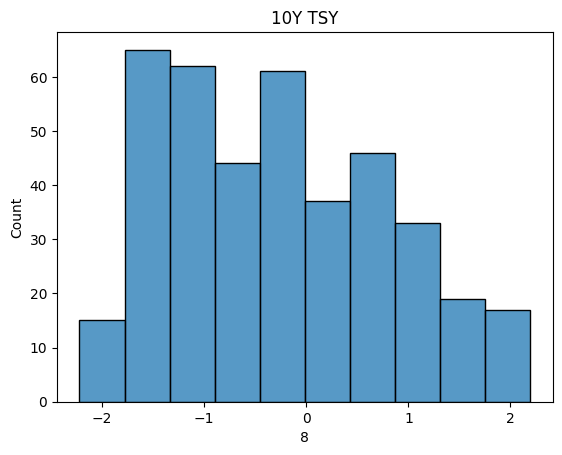

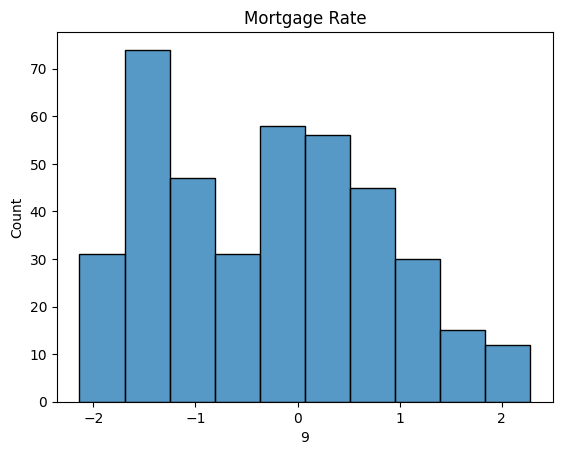

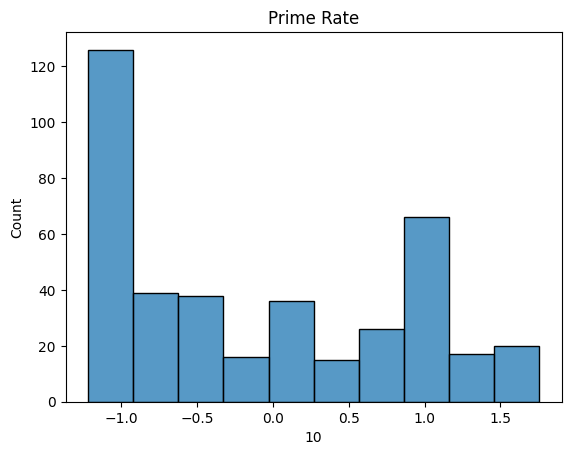

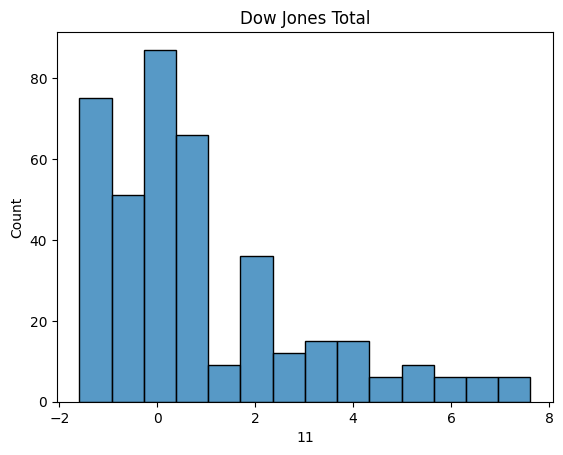

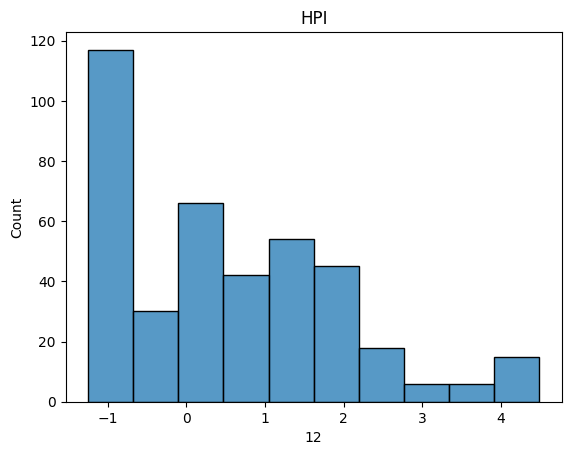

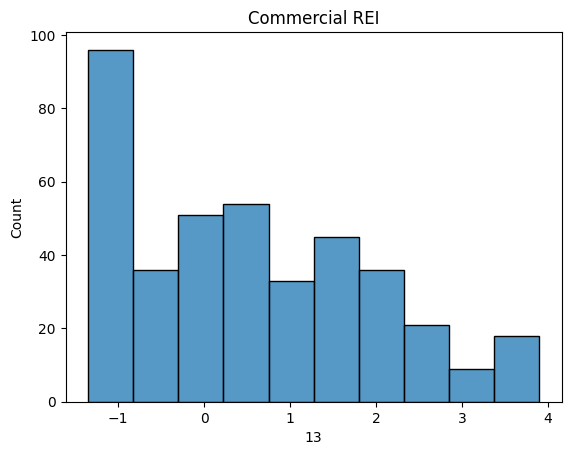

In [ ]:
jodo = pd.concat([pd.DataFrame(scaled_t_train),pd.DataFrame(scaled_t_test)],axis = 0)
for i in range (len(cols)):
  #plt.subplot(i+1,1,1)
  plt.figure()
  #plt.subplot(nrows = 3,ncols =5)
  sns.histplot(jodo.iloc[:,i])
  plt.title(ccardata_comb.columns[i])
  plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
model = pca.fit(scaled_t_train)
pca_train = model.transform(scaled_t_train)
pca_test = model.transform(scaled_t_test)
n_comp = model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_comp)]
initial_feature_names = ['Real GDP', 'Nom GDP', 'Real Disp Income', 'Nom Disp Income',
       'Unemp Rate', 'CPI', '3m TSY', '5Y TSY', '10Y TSY', 'Mortgage Rate',
       'Prime Rate', 'Dow Jones Total', 'HPI', 'Commercial REI']
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_comp)]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_comp)}
df = pd.DataFrame(sorted(dic.items()))
pca_train[:,0]

array([ 4.77473339,  4.90324962,  5.03838347,  5.61732999,  5.62050661,
        5.5482011 ,  5.0321024 ,  5.02351911,  5.03360565,  4.69819906,
        4.54272643,  4.34814855,  3.53663894,  3.32665809,  3.34116887,
        3.64778829,  3.53449587,  3.61929538,  4.21412682,  4.01277829,
        3.7956738 ,  3.46855206,  3.25493651,  2.94726479,  2.76267533,
        2.85550132,  3.03910112,  3.54676395,  3.46193346,  3.35156828,
        2.82165482,  2.65476383,  2.52432532,  2.42383343,  2.60341191,
        2.64414539,  2.59795394,  2.43445271,  2.29380883,  1.79327499,
        1.82162274,  1.83212402,  1.95462797,  1.88303758,  1.75467424,
        1.56858433,  1.70611852,  1.79229954,  2.25707358,  2.35977725,
        2.6068194 ,  2.76501159,  3.13153358,  3.18968719,  3.50057218,
        3.58587604,  3.69703458,  3.49185873,  3.75502527,  3.88149432,
        4.25179744,  4.21208799,  4.0401172 ,  3.38437679,  3.22279225,
        2.95877264,  2.69692084,  2.76804971,  2.71492081,  2.92

In [ ]:
model.components_


array([[ 0.10868293,  0.1497905 ,  0.06686616,  0.11795939, -0.13785892,
        -0.34290798,  0.32319511,  0.34619861,  0.34541968,  0.34232669,
         0.31234328, -0.28353501, -0.28685699, -0.29954319],
       [-0.42217871, -0.40700342, -0.4221224 , -0.44080185,  0.33270766,
        -0.11632693, -0.06380403,  0.02018692,  0.07379187,  0.0765482 ,
        -0.07906824, -0.27644277, -0.19475777, -0.15168091],
       [ 0.14665755,  0.07971041,  0.35806808,  0.32305995,  0.54529581,
        -0.05790524, -0.27894831, -0.12837151, -0.04310705, -0.08135683,
        -0.31900114, -0.2396084 , -0.28622642, -0.30820247],
       [ 0.54708286,  0.51569403, -0.46967845, -0.3980972 ,  0.07713717,
        -0.01780737, -0.08757404, -0.05656973, -0.03922408, -0.07127262,
        -0.0956387 , -0.00823252, -0.0663262 , -0.13532249],
       [-0.0543808 ,  0.2442126 , -0.14996522,  0.1907826 ,  0.51949663,
         0.09537431,  0.11764537,  0.14621529,  0.21322564,  0.18647599,
         0.06619541, -0.26

In [ ]:
df

,0,1
0,PC1,5Y TSY
1,PC2,Nom Disp Income
2,PC3,Unemp Rate
3,PC4,Real GDP
4,PC5,HPI


### Time Series Analysis


In [ ]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

In [ ]:
for i in range(len(cols)+1):
  print('\n\n', ccardata_comb.columns[i], ':')
  adfcnt = 0
  adf = adfuller(ccardata_comb.iloc[:,i])
  if adf[1] < 0.05:
    adfcnt = 1
    # print('ADFuller Test of Stationarity', ccardata_comb.columns[i], adf[0:2])
  # else:
    # print('ADFuller Test of Stationarity', ccardata_comb.columns[i], 'is not stationary')

  kpcnt = 0
  kpstest = kpss(ccardata_comb.iloc[:,i])
  if kpstest[1] > 0.05:
    kpcnt = 1
    # print('KPSS test of Stationarity', ccardata_comb.columns[i], kpstest[0:2])
  # else:
    # print('KPSS test of Stationarity', ccardata_comb.columns[i], 'is not stationary')

    # ('Compared ADF and KPSS Tests')
  if adfcnt == 1 and kpcnt == 0:
    print('is difference stationary by comparison of ADF and KPSS test')
  elif adfcnt == 0 and kpcnt == 1:
    print('is trend stationary by comparison of ADF and KPSS test')
  elif adfcnt == 0 and kpcnt == 0:
    print('is not stationary by ADF and KPSS test')
  else:
    print('is stationary by ADF and KPSS test')

  ppcnt = 0
  pptest = PhillipsPerron(ccardata_comb.iloc[:,i])
  if pptest.pvalue< 0.05:
    print('Is stationary by Phillips Perron test')
    # print(pptest.stat, pptest.pvalue)
    ppcnt = 1
  else:
    print('Is NOT stationary by Phillips Perron test')



 Real GDP :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 Nom GDP :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 Real Disp Income :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 Nom Disp Income :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 Unemp Rate :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 CPI :
is not stationary by ADF and KPSS test
Is NOT stationary by Phillips Perron test


 3m TSY :
is difference stationary by comparison of ADF and KPSS test
Is NOT stationary by Phillips Perron test


 5Y TSY :
is not stationary by ADF and KPSS test
Is NOT stationary by Phillips Perron test


 10Y TSY :
is not stationary by ADF and KPSS test
Is NOT stationary by Phillips Perron test


 Mortgage Rate :
is not stationary by ADF and KPSS test
Is NOT stationary by Phillips Perron test


 Prime Rate :
is difference stationary by comparison of 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the 

Is NOT stationary by Phillips Perron test


 Commercial REI :
is not stationary by ADF and KPSS test
Is NOT stationary by Phillips Perron test


 VIX :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Seasonality Code

In [ ]:
import statsmodels.api as sm

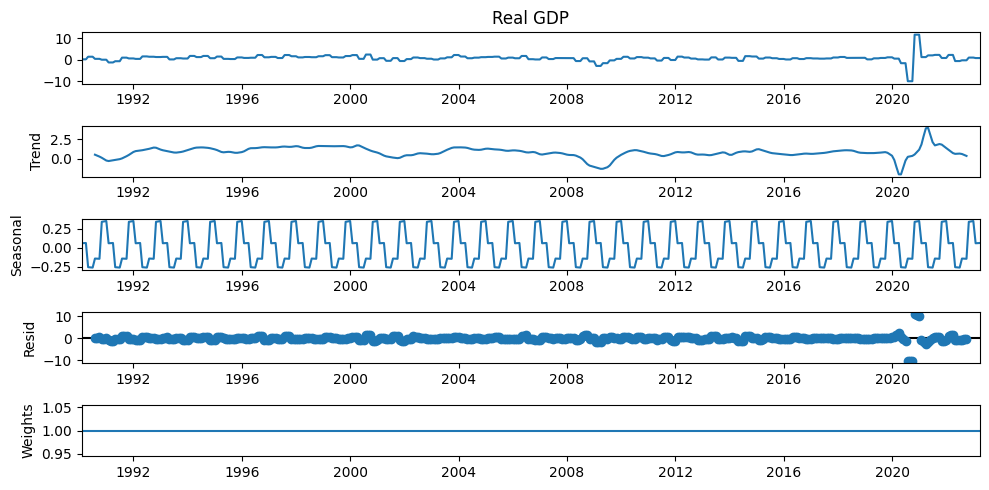

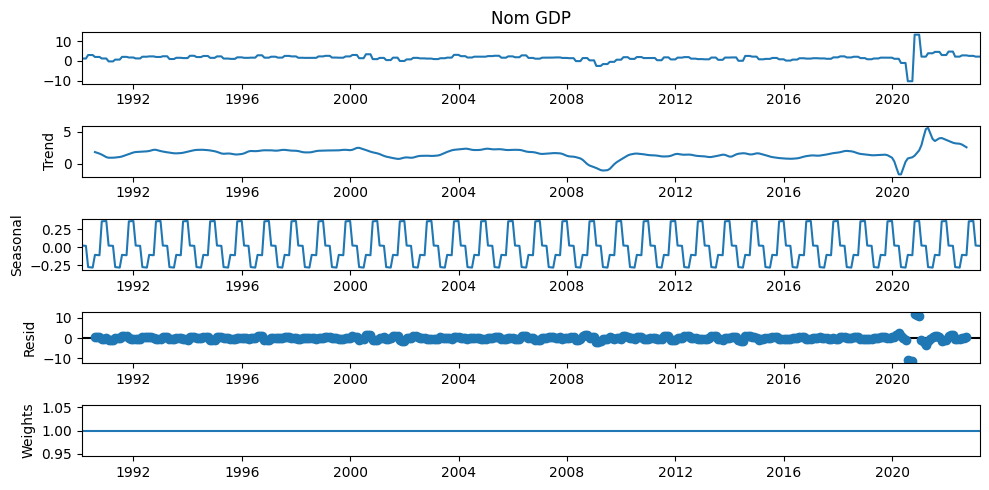

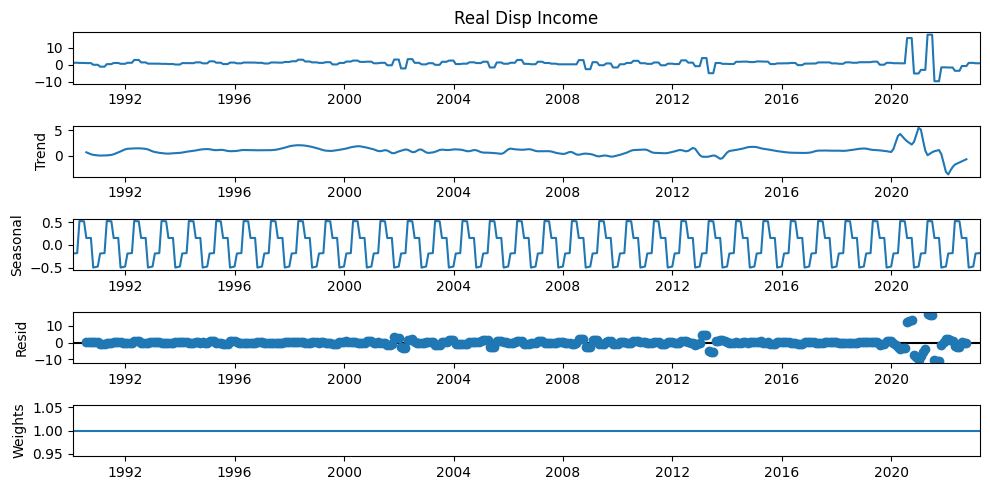

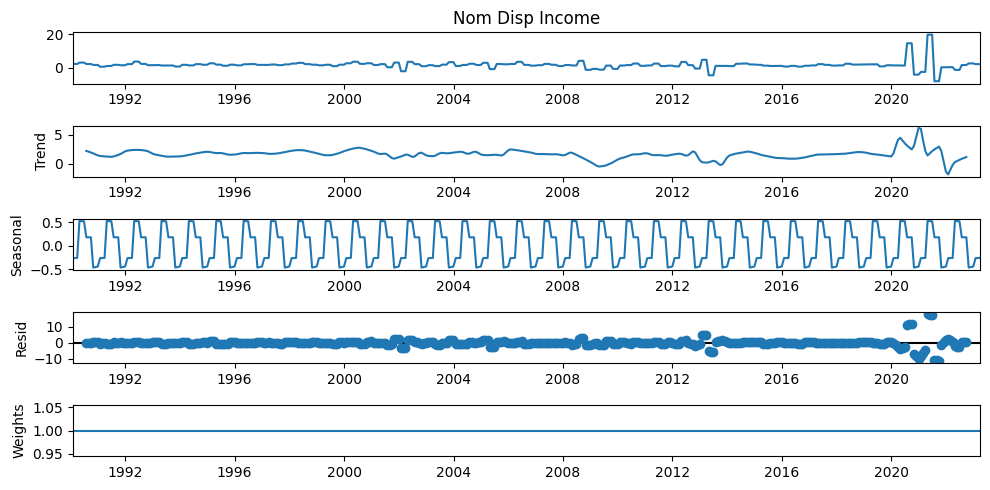

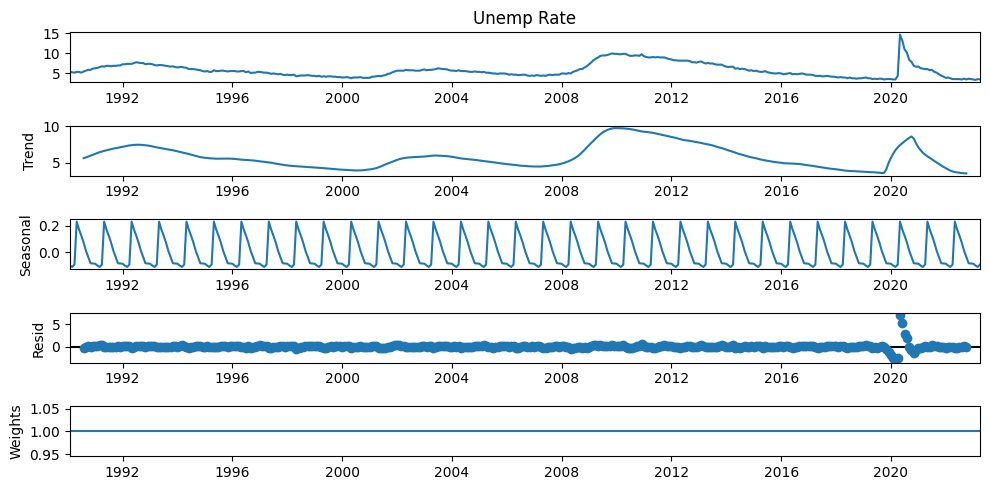

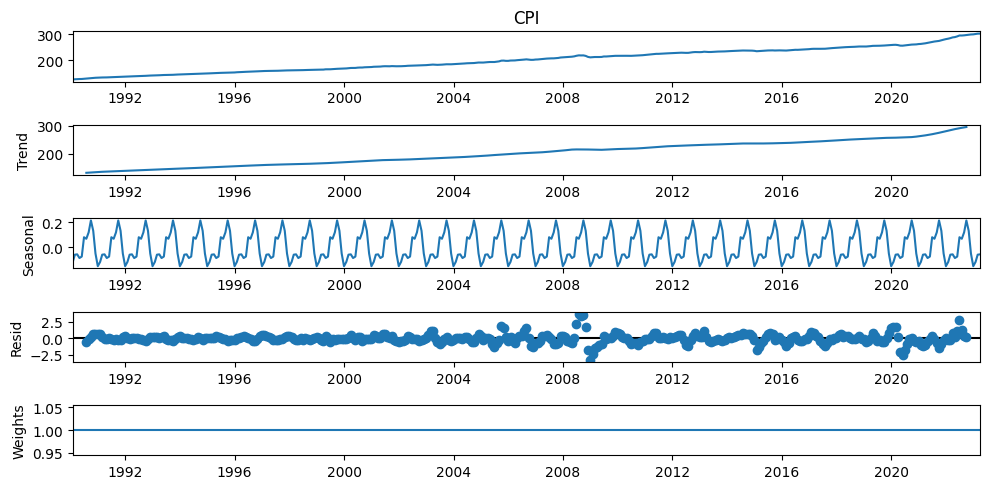

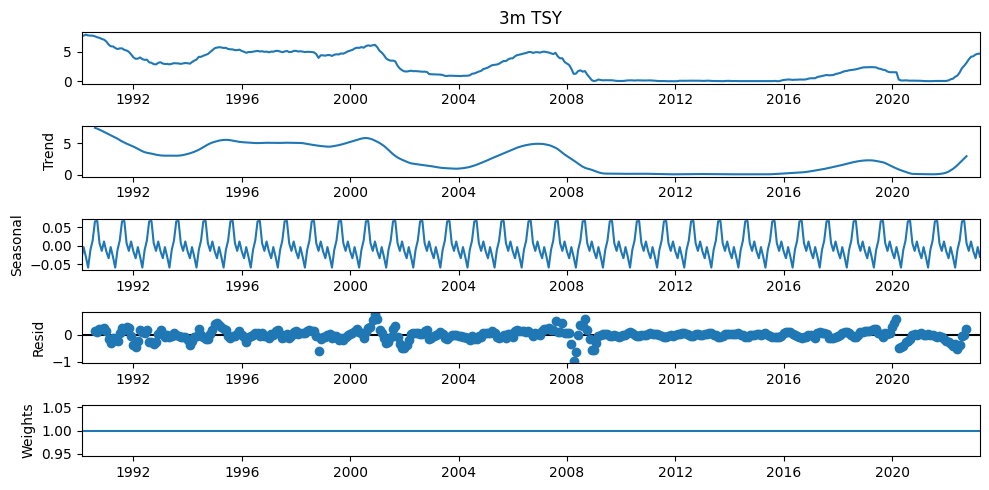

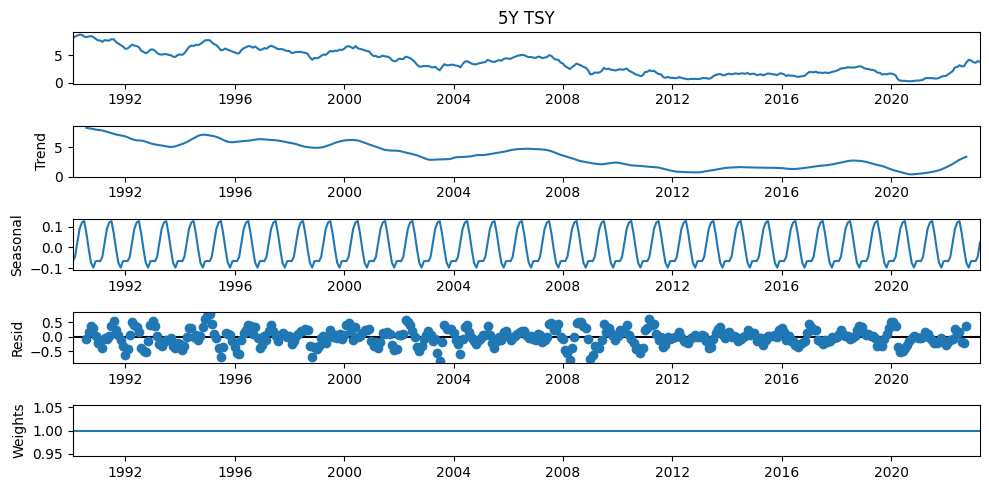

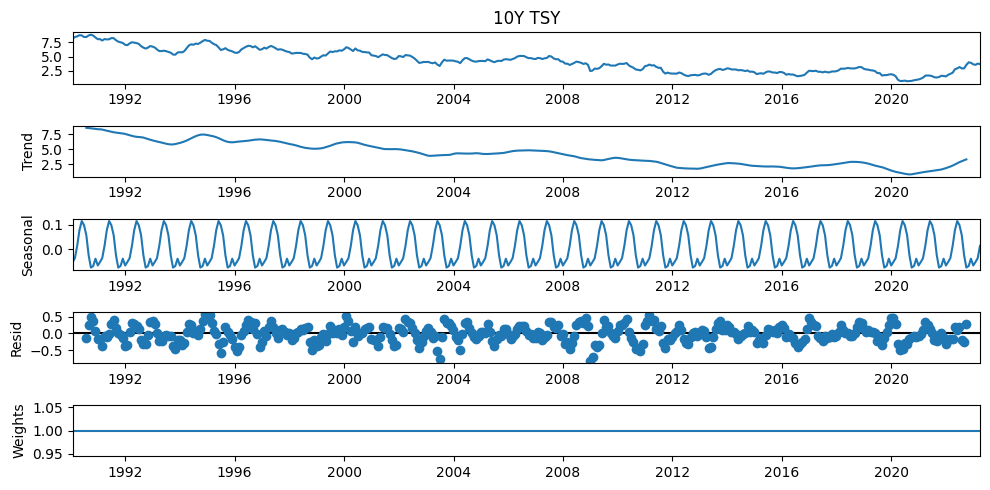

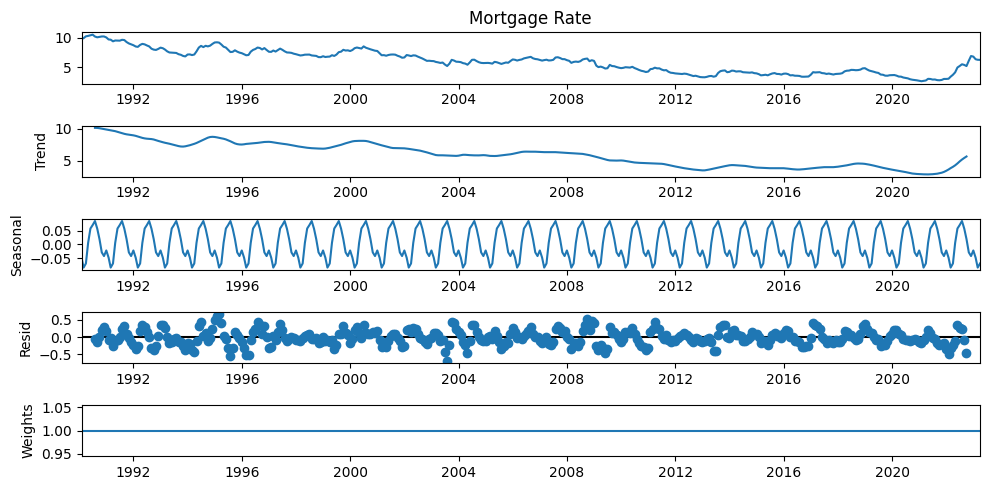

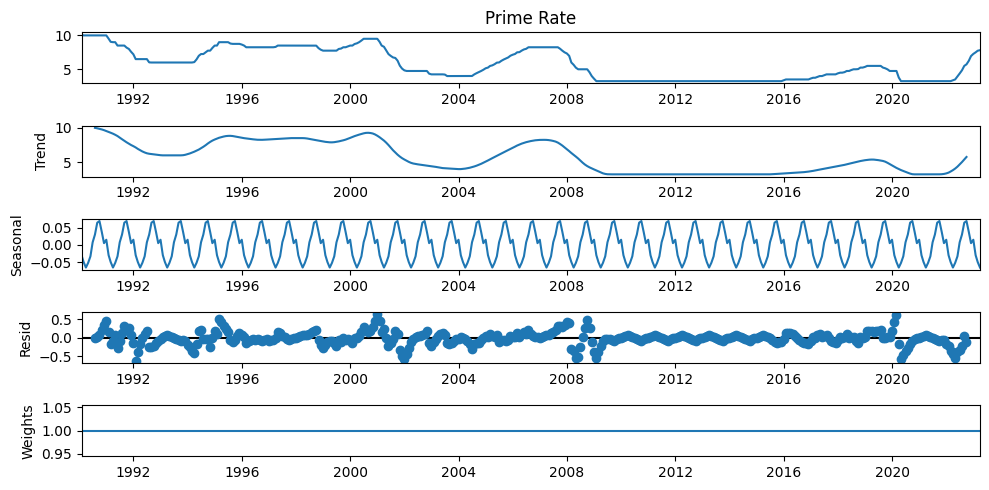

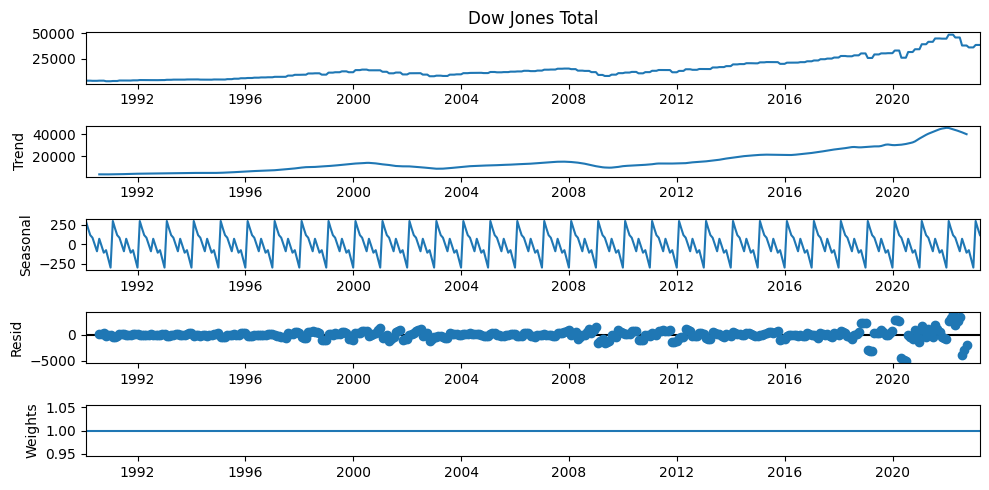

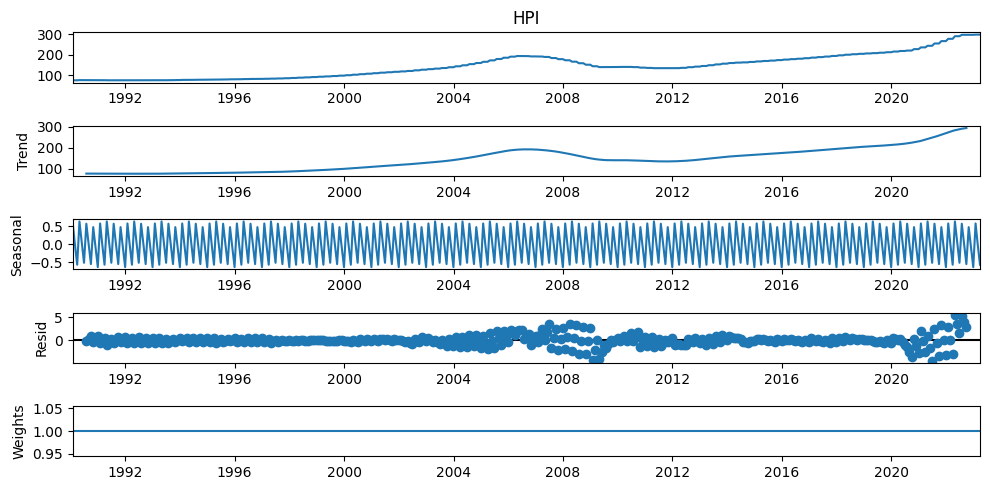

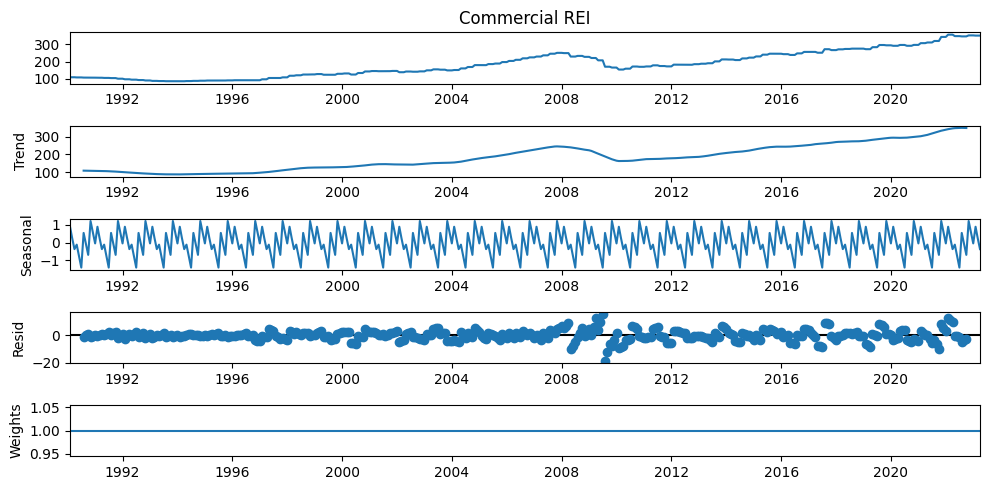

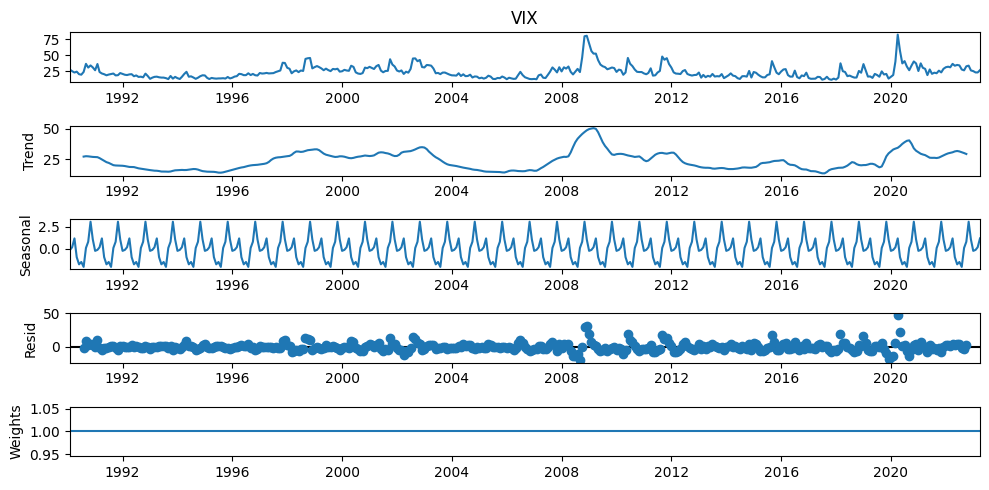

In [ ]:
def seasonalitycheck(vardata):
  dta = vardata.resample("M").fillna(method="ffill")
  res = sm.tsa.seasonal_decompose(dta)
  fig = res.plot(weights = True)
  fig.set_size_inches(10, 5)
  plt.tight_layout()
  return

# for i in range(len(ccardata_comb.columns)):
#   seasonalitycheck(ccardata_comb.iloc[:,i])

seasonalitycheck(ccardata_comb.iloc[:,1])

In [ ]:
data_columns = ccardata_comb.columns
for column in data_columns:
    seasonal_decomposition = sm.tsa.seasonal_decompose(ccar_new_check[column], model='additive')

    # Plot the original time series, trend, seasonal, and residual components
    fig, ax = plt.subplots(4, 1, figsize=(10, 8))
    ax[0].plot(ccar_new_check.index, ccar_new_check[column], label='Original')
    ax[0].legend(loc='best')
    ax[1].plot(ccar_new_check.index, seasonal_decomposition.trend, label='Trend')
    ax[1].legend(loc='best')
    ax[2].plot(ccar_new_check.index, seasonal_decomposition.seasonal, label='Seasonal')
    ax[2].legend(loc='best')
    ax[3].plot(ccar_new_check.index, seasonal_decomposition.resid, label='Residual')
    ax[3].legend(loc='best')

    # Set the title of the plot as the column name
    ax[0].set_title(column)

    # Show the plots
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
help(seasonal_decomposition)

Help on DecomposeResult in module statsmodels.tsa.seasonal object:

class DecomposeResult(builtins.object)
 |  DecomposeResult(observed, seasonal, trend, resid, weights=None)
 |  
 |  Results class for seasonal decompositions
 |  
 |  Parameters
 |  ----------
 |  observed : array_like
 |      The data series that has been decomposed.
 |  seasonal : array_like
 |      The seasonal component of the data series.
 |  trend : array_like
 |      The trend component of the data series.
 |  resid : array_like
 |      The residual component of the data series.
 |  weights : array_like, optional
 |      The weights used to reduce outlier influence.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, observed, seasonal, trend, resid, weights=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  plot(self, observed=True, seasonal=True, trend=True, resid=True, weights=False)
 |      Plot estimated components
 |      
 |      Parameters
 |      ----------
 |      